# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**
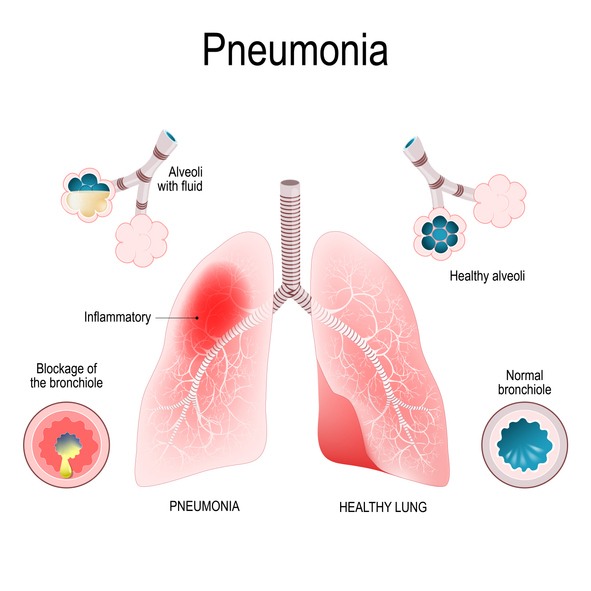

In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing the necessary libraries

In [36]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Scikit-optimize
from skopt import BayesSearchCV


# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [37]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    return np.array(data, dtype=object)

# Loading the Dataset

In [38]:
# TODO: add your own paths here
train = get_training_data('data/chest_xray/train')
test = get_training_data('data/chest_xray/test')
val = get_training_data('data/chest_xray/val')


# Data Visualization & Preprocessing

/opt/anaconda3/envs/environment/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

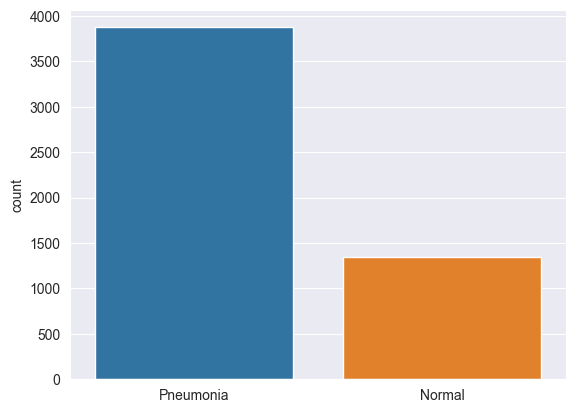

In [39]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

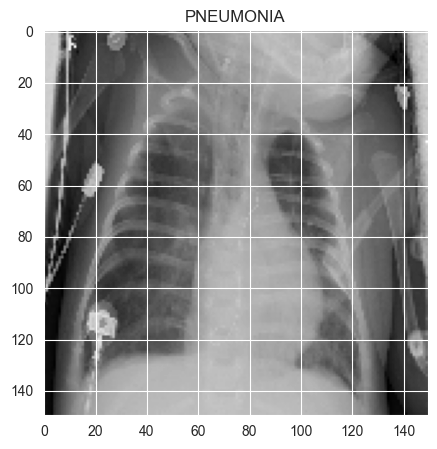

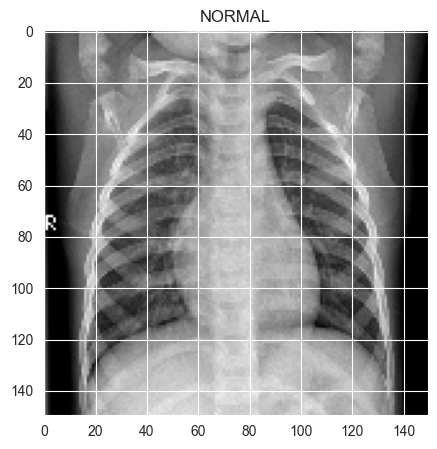

In [40]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [41]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [42]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [43]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [44]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, we choosed to:
1. Randomly rotate some training images by 60 degrees 
2. Randomly Zoom by 60% some training images
3. Randomly shift images horizontally by 50% of the width 
4. Randomly shift images vertically by 20% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Create model function

In [45]:
def create_model(learning_rate=0.001, dropout_rate=0.2, dropout_rate_conv=0.2):
    model = Sequential()
    
    # First Conv Layer
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Second Conv Layer
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Third Conv Layer
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Fourth Conv Layer
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Fifth Conv Layer
    model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(dropout_rate_conv))  # Tunable dropout rate
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    
    # Flatten Layer
    model.add(Flatten())
    
    # Fully Connected Dense Layer
    model.add(Dense(units=128, activation='relu'))  # Tunable units
    model.add(Dropout(dropout_rate))  # Tunable dropout rate
    
    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define the Hyperparameter Search Space

In [46]:
model = KerasClassifier(build_fn=create_model, epochs=12, batch_size=32, verbose=1)

# Define the hyperparameter search space
param_space = {
    'learning_rate': (1e-5, 1e-2, 'log-uniform'),  # Log scale for learning rate
    'dropout_rate': (0.05, 0.4),  # Dropout rate between 0.2 and 0.5
    'dropout_rate_conv': (0.1, 0.4) 
}

/var/folders/_l/qwh50rw95fn2s7xfqrd_5n7w0000gn/T/ipykernel_52648/2189171.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=12, batch_size=32, verbose=1)


# Implement Bayesian Optimization Using BayesSearchCV

In [47]:

# Initialize BayesSearchCV
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=6,  # You can increase this
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=1
)
# Perform the optimization
opt.fit(x_train, y_train)

# Get the best hyperparameters
print("Best parameters found: ", opt.best_params_)
print("Best accuracy: ", opt.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/12
109/109 [==============================] - 24s 214ms/step - loss: 0.9902 - accuracy: 0.8576
Epoch 2/12
109/109 [==============================] - 23s 215ms/step - loss: 0.2138 - accuracy: 0.9215
Epoch 3/12
109/109 [==============================] - 22s 204ms/step - loss: 0.1728 - accuracy: 0.9330
Epoch 4/12
109/109 [==============================] - 23s 207ms/step - loss: 0.1338 - accuracy: 0.9442
Epoch 5/12
109/109 [==============================] - 22s 202ms/step - loss: 0.1152 - accuracy: 0.9580
Epoch 6/12
109/109 [==============================] - 22s 202ms/step - loss: 0.1079 - accuracy: 0.9546
Epoch 7/12
109/109 [==============================] - 22s 206ms/step - loss: 0.0971 - accuracy: 0.9623
Epoch 8/12
109/109 [==============================] - 22s 202ms/step - loss: 0.0856 - accuracy: 0.9664
Epoch 9/12
109/109 [==============================] - 23s 211ms/step - loss: 0.0823 - accuracy: 0.9715
Epoch 10/12
10

# Training the Model

In [23]:
print(opt.best_params_['batch_size'])

59


In [27]:
batch_size = opt.best_params_['batch_size']
dropout_rate = opt.best_params_['dropout_rate']
learning_rate = opt.best_params_['learning_rate']
units = opt.best_params_['units']

best_model = create_model(learning_rate, units, dropout_rate)

print("Loss of the model is - " , best_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , best_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 59ms/step - loss: 0.6917 - accuracy: 0.6234
Loss of the model is -  0.6916844248771667
20/20 [==============================] - 1s 57ms/step - loss: 0.6917 - accuracy: 0.6234
Accuracy of the model is -  62.33974099159241 %


In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [42]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 98s 594ms/step - loss: 0.5870 - accuracy: 0.8407 - val_loss: 40.9226 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 96s 588ms/step - loss: 0.2741 - accuracy: 0.8967 - val_loss: 38.1242 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9139
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 96s 589ms/step - loss: 0.2457 - accuracy: 0.9139 - val_loss: 46.3627 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 96s 590ms/step - loss: 0.1514 - accuracy: 0.9438 - val_loss: 0.5793 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 98s 598ms/step - loss: 0.1367 - accuracy: 0.9557 - val_loss: 14.4477 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [=================

In [43]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 131ms/step - loss: 0.2483 - accuracy: 0.9119
Loss of the model is -  0.24834510684013367
20/20 [==============================] - 3s 128ms/step - loss: 0.2483 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


# Analysis after Model Training

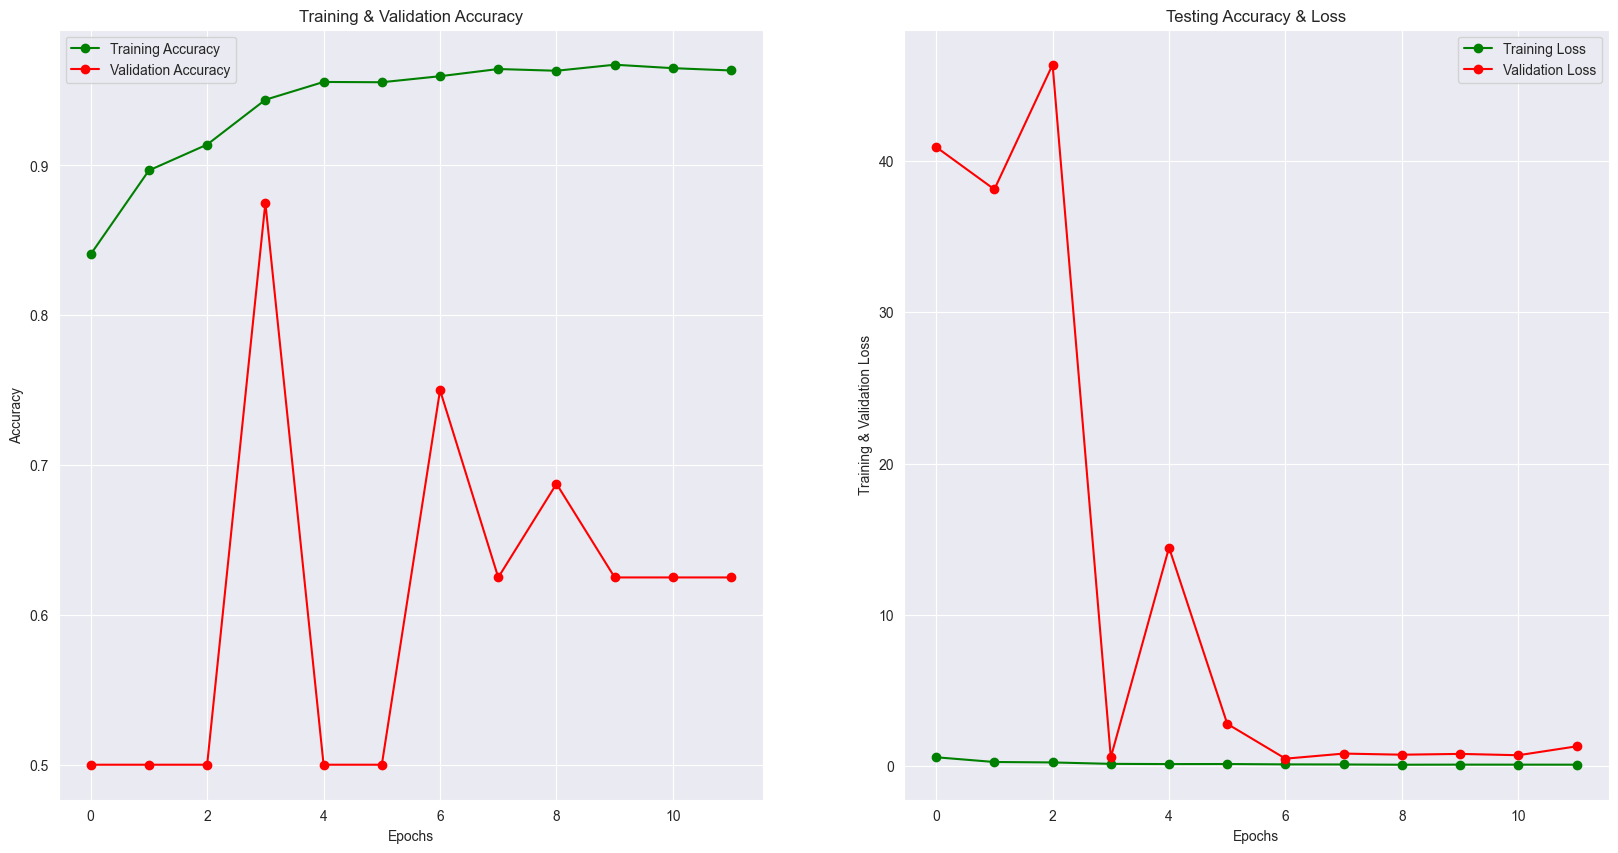

In [44]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [45]:
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype("int32")
predicted_classes[:15]

20/20 [==============================] - 3s 141ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [46]:
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.92      0.93       390
   Normal (Class 1)       0.87      0.90      0.88       234

           accuracy                           0.91       624
          macro avg       0.90      0.91      0.91       624
       weighted avg       0.91      0.91      0.91       624



In [47]:
cm = confusion_matrix(y_test, predicted_classes)
cm


array([[359,  31],
       [ 24, 210]], dtype=int64)

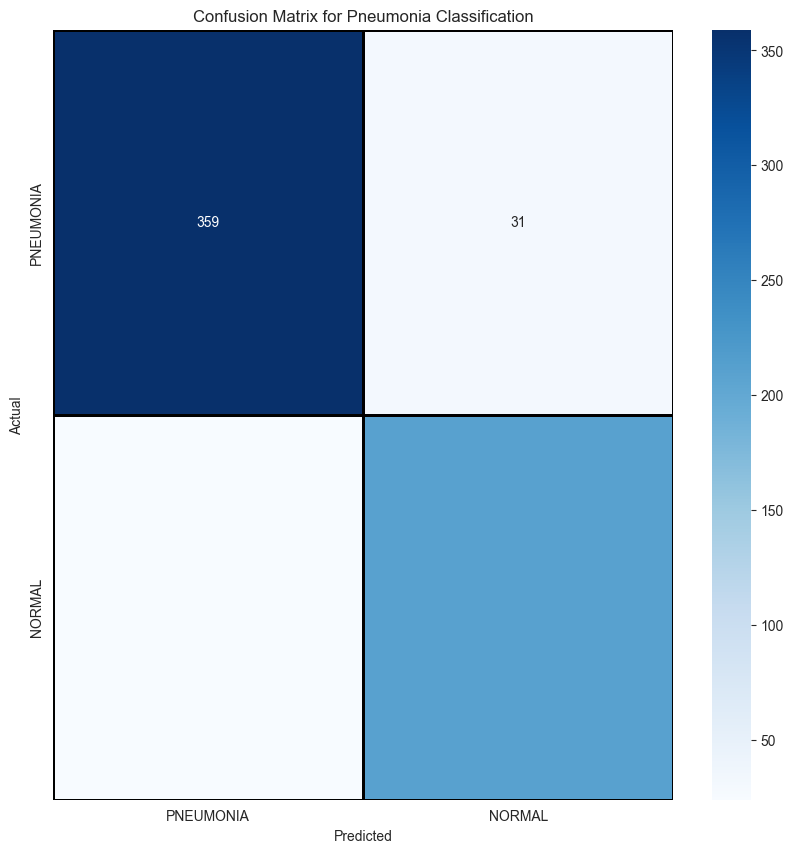

In [48]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1,
         annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Pneumonia Classification")
plt.show()


- There is a bug in the Seaborn library version being used (`0.12.0`), which causes only the top value to be filled in.  
- Unfortunately, the Seaborn library can't be updated since it conflicts with other dependencies.  
- So there is no quick fix for this — only creating the plot in a separate file using the up-to-date Seaborn library.  
- Run `pip install seaborn --upgrade` in a different environment to create a proper plot.


In [49]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

In [50]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

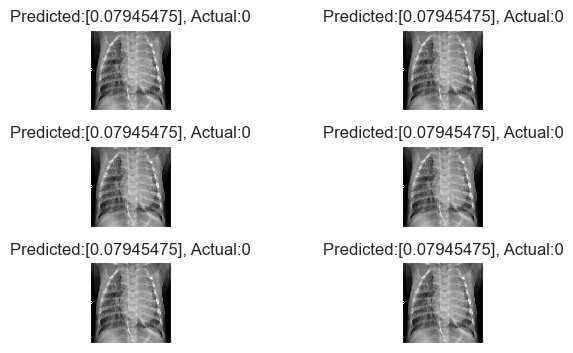

In [64]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted:{}, Actual:{}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1